In [2]:
import numpy as np
import pandas as pd
import pickle as pkl
import xarray as xr
import copy
import os
import sys
sys.path.append(os.path.realpath('../split-data/'))
import return_period_tools
import metrics
import random
import matplotlib as mpl
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
font = {'family' : 'sans-serif','size'   : 6}
mpl.rc('font', **font)
mpl.rcParams['axes.labelsize'] = 6
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6
mpl.rcParams['legend.fontsize'] = 5
mpl.rcParams['lines.markersize'] = 1.5
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams["axes.titlesize"] = 8
mpl.rcParams["grid.color"] = "#dddddd"
mpl.rcParams["grid.linewidth"] = 0.5
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [3]:
#Utility function to create a matplotlib figure with cm sizes

def cm2inch(width: float, height: float) -> tuple:
    """Converts figure size from centimeters to inch.
    
    Parameters
    ----------
    width : float
        Width of figure in centimeters
    height : float
        Height of figure in centimeters
    
    Returns
    -------
    Tuple[float, float]
        Tuple containing width and height in inches
    """
    inch = 2.54
    return (width / inch, height / inch)

In [4]:
xr.__version__

'0.16.1'

In [6]:
# Convert flow to   CFS mm -> ft     km^2 -> ft^2    hr->s
conversion_factor = 0.00328084 * 10763910.41671 / 3600 / 24

In [11]:
# Get a list of all the basins in the analysis
basin_list = list(lstm_results_time_split.keys())

# Camels attributes with RI information
dataName = '../data/camels_attributes.csv.csv'
# load the data with pandas
pd_attributes = pd.read_csv(dataName, sep=',', index_col='gauge_id')

# Add the basin ID as a 8 element string with a leading zero if neccessary
basin_id_str = []
for a in pd_attributes.index.values:
    basin_id_str.append(str(a).zfill(8))
pd_attributes['basin_id_str'] = basin_id_str

In [13]:

#-------------------------------------------------------------------------------------------------
analysis_dict_name_nwm_train = 'frequency_analysis_dict_annual_MC_daily_nwm_sac_nwm.pkl'
peak_flows_dict_name_nwm_train = 'peak_annual_flows_dictionary_annual_nwm.pkl'
analysis_dict_name_hp_train = 'frequency_analysis_dict_annual_MC_daily_nwm_sac_hp.pkl'
peak_flows_dict_name_hp_train = 'peak_annual_flows_dictionary_annual_hp.pkl'
#-------------------------------------------------------------------------------------------------


load_data=True
if load_data:
    with open(analysis_dict_name_nwm_train, 'rb') as fb:
        analysis_dict_all['time_split'] = pkl.load(fb)
    with open(peak_flows_dict_name_nwm_train, 'rb') as fb:
        peak_flows_dict_nwm_train = pkl.load(fb)
    with open(analysis_dict_name_hp_train, 'rb') as fb:
        analysis_dict_all['return_period_split'] = pkl.load(fb)


In [14]:
all_metrics = ['NSE','MSE','RMSE','KGE','Alpha-NSE','Pearson-r','Beta-NSE','FHV','FMS','FLV','Peak-Timing',
               'beta-abs', 'peakQ', 'peakRI', 'peakT', 'peakQ-perc', 'peakRI-perc', 'peakT-abs']


In [15]:
analysis_dict={}
analysis_dict['time_split'] = {metric:{model:[] for model in models_ri} for metric in all_metrics}
analysis_dict['hp'] = {metric:{model:[] for model in models_ri} for metric in all_metrics}
for ib, basin_0str in enumerate(basin_list):
    for metric in all_metrics:
        for model in models_ri:
            analysis_dict['time_split'][metric][model].extend(analysis_dict_all['time_split'][basin_0str][metric][model])
            analysis_dict['hp'][metric][model].extend(analysis_dict_all['hp'][basin_0str][metric][model])

In [16]:
ylimz_bar = {'NSE':[0,1], 'MSE':[0,7], 'RMSE':[0,3.5], 'KGE':[0,1], 'Alpha-NSE':[0,1], 'Pearson-r':[0,1], 
         'Beta-NSE':[-0.1,0.1], 'FHV':[-40,10], 'FMS':[-45,0],'FLV':[-60,60], 'Peak-Timing':[0,1],
          'beta-abs':[0,0.25], 'peakQ':[-7500, 0], 'peakRI':[-300,150], 'peakT':[-1,1], 
          'peakQ-perc':[0,0.6], 'peakRI-perc':[0,1], 'peakT-abs':[0,12]}
xlimz_freq = {'NSE':[-1,1], 'MSE':[0,1], 'RMSE':[0,0.7], 'KGE':[-1,1], 'Alpha-NSE':[0,1], 'Pearson-r':[0,1], 
         'Beta-NSE':[-0.4,0.1], 'FHV':[-60,60], 'FMS':[0,-60],'FLV':[-25,25], 'Peak-Timing':[-1,1],
          'beta-abs':[0,0.4], 'peakQ':[-20000, 0], 'peakRI':[-300,150], 'peakT':[-1,1], 
          'peakQ-perc':[0,1], 'peakRI-perc':[0,1.3], 'peakT-abs':[0,2.2]}
namz = {'NSE':'Nash–Sutcliffe efficiency', 'MSE':'Mean squared error', 'RMSE':'Root mean squared error', 
        'KGE':'Kling-Gupta efficiency', 'Alpha-NSE':'Alpha-NSE: Flow variance', 'Pearson-r':'Pearson-r', 
         'Beta-NSE':'Beta-NSE: Volume bias', 'FHV':'FHV: Top 2 % peak flow bias', 
         'FMS':'FMS: Bias of FDC midsegment slope','FLV':'FLV: 30 % low flow bias', 
         'Peak-Timing':'Peak-Timing error','beta-abs':'Absolute volume bias', 'peakQ':'Peak flow error', 
         'peakRI':'Peak recurrence interval error', 'peakT':'Timing error of peak flow', 
         'peakQ-perc':'Abs. percent error of peak flow', 'peakRI-perc':'Abs. percent error of recurrence', 
         'peakT-abs':'Absolute timing error of peak flow'}
legend_locz = {'NSE':'upper right', 'MSE':'upper left', 'RMSE':'upper left', 
        'KGE':'upper right', 'Alpha-NSE':'lower right', 'Pearson-r':'lower right', 
         'Beta-NSE':'lower left', 'FHV':'lower left', 'FMS':'lower right','FLV':'upper right', 
         'Peak-Timing':'upper right','beta-abs':'upper right', 'peakQ':'lower left', 
         'peakRI':'lower left', 'peakT':'lower left', 
         'peakQ-perc':'upper left', 'peakRI-perc':'upper left', 'peakT-abs':'upper center'}
colz = {'NSE':2, 'MSE':1, 'RMSE':1, 'KGE':2, 'Alpha-NSE':2, 'Pearson-r':1, 
         'Beta-NSE':1, 'FHV':1, 'FMS':1,'FLV':2, 'Peak-Timing':1,
          'beta-abs':2, 'peakQ':1, 'peakRI':1, 'peakT':1, 
          'peakQ-perc':1, 'peakRI-perc':1, 'peakT-abs':1}

In [17]:
model_label_list = ['LSTM', 'MC-LSTM', 'SAC-SMA', 'NWM*']
model_name_list = ['lstm', 'mc', 'sac', 'nwm']
model_colors = ['b', 'orange', 'red', 'red']
model_style = ['-', '-', '-', '--']
model_name_label_dict = {model_name:model_label for model_name, model_label in \
                         zip(model_name_list,model_label_list)}
model_ri_list = ['ri', 'lstm', 'mc', 'sac', 'nwm']
train_types = ['time_split','return_period_split']

base_metrics = metrics.get_available_metrics()

In [18]:
plot_metrics = ['NSE','KGE','Alpha-NSE','Pearson-r','Beta-NSE','FHV','FMS','FLV','Peak-Timing']
ppm = {'NSE':'NSE','KGE':'KGE','Alpha-NSE':'Alpha-NSE',
       'Pearson-r':'Pearson-r','Beta-NSE':'Beta-NSE',
       'FHV':'FHV','FMS':'FMS','FLV':'FLV','peakT-abs':'Peak-Timing'}

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


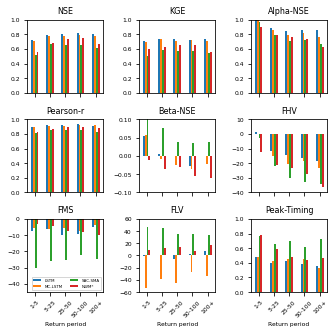

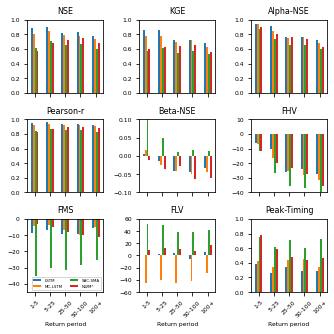

In [19]:
# Big tables for each training type

count_missing = {train_type:{} for train_type in train_types}
for train_type in train_types:
    
    fig = plt.figure(figsize=cm2inch(12,12))
    
    ri_list = {metric:{} for metric in all_metrics}
    ri_bins = {metric:{} for metric in all_metrics}
    for imetric, metric in enumerate(plot_metrics):
        bin_max=[5, 25,50,100,1000000000]
        bin_names=['1-5', '5-25','25-50','50-100','100+']
        ri_list[metric][train_type] = {model_label:{bin_name:[] for bin_name in bin_names} for \
                                       model_label in model_label_list}
        ri_bins[metric][train_type] = {model_label:{bin_name:[] for bin_name in bin_names} for \
                                       model_label in model_label_list}

        ri_bins[metric][train_type]['count'] = {bin_name:0 for bin_name in bin_names}

        count_missing[train_type][metric] = {model_ri:0 for model_ri in model_ri_list}
        for i, ri in enumerate(analysis_dict[train_type][metric]['ri']):
            if analysis_dict[train_type][metric]['ri'][i] is None:
                continue

            skip_this=False
            for icheck in model_ri_list:
                if analysis_dict[train_type][metric][icheck][i] is None:
                    skip_this=True
                    count_missing[train_type][metric][icheck]+=1
                if np.isinf(analysis_dict[train_type][metric][icheck][i]):
                    skip_this=True
                    count_missing[train_type][metric][icheck]+=1
                if isinstance(analysis_dict[train_type][metric][icheck][i], str):
                    skip_this=True
                    count_missing[train_type][metric][icheck]+=1
                if analysis_dict[train_type][metric][icheck][i] != \
                                     analysis_dict[train_type][metric][icheck][i]:
                    skip_this=True
                    count_missing[train_type][metric][icheck]+=1

            if skip_this:
                continue
                skip_this=False

            for maxv,bin_name in zip(bin_max, bin_names):
                if ri<maxv:
                    ri_bins[metric][train_type]['count'][bin_name]+=1
                    for model_name, model_label in zip(model_name_list, model_label_list):
                        ri_list[metric][train_type][model_label][bin_name].append( \
                                                        analysis_dict[train_type][metric][model_name][i])
                    break


        for maxv,bin_name in zip(bin_max, bin_names):
            if ri_bins[metric][train_type]['count'][bin_name] < 1:
                continue
            for model_label in model_label_list:
                if metric in ['Peak-Timing', 'peakT-abs']:
                    ri_bins[metric][train_type][model_label][bin_name] = np.nanmean( \
                                                ri_list[metric][train_type][model_label][bin_name])
                else:
                    ri_bins[metric][train_type][model_label][bin_name] = np.nanmedian( \
                                                ri_list[metric][train_type][model_label][bin_name])
                
        ax = fig.add_subplot(3, 3, imetric+1)    
        pd.DataFrame(ri_bins[metric][train_type])[model_label_list].plot.bar(ax=ax)

        if imetric+1 in [7,8,9]:
            ax.set_xticklabels(bin_names, rotation = 45)
            ax.set_xlabel("Return period")
        else:
            ax.set_xticklabels([])

        ax.set_title(metric)
        ax.set_ylim(ylimz_bar[metric])
        if metric =='FMS':
            ax.legend(fontsize=4, ncol=2, loc='lower right')
        else:
            ax.get_legend().remove()

            
    fig.tight_layout(pad=1)
#     fig.savefig('figs/paper-mc-lstm-4june2021/bars_{}_training.pdf'.format(train_type), dpi=600)
#     fig.savefig('figs/paper-mc-lstm-4june2021/bars_{}_training.png'.format(train_type), dpi=600)
    plt.show()
    plt.close()

Nash–Sutcliffe efficiency
                    LSTM   MC-LSTM   SAC-SMA      NWM*  count
1-5 \n n=5969   0.719247  0.712516  0.515655  0.562149   6175
5-25 \n n=1260  0.784970  0.779264  0.665498  0.676144   1309
25-50 \n n=185  0.804685  0.775546  0.657455  0.732404    191
50-100 \n n=91  0.822320  0.791938  0.659114  0.748473     97
100+ \n n=84    0.806885  0.778151  0.615436  0.673697     87


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


                    LSTM   MC-LSTM   SAC-SMA      NWM*  count
1-5 \n n=5969   0.883635  0.808350  0.616394  0.565467   5969
5-25 \n n=1260  0.904132  0.845105  0.704568  0.679615   1260
25-50 \n n=185  0.814567  0.789172  0.656225  0.720008    185
50-100 \n n=91  0.831189  0.781486  0.668932  0.748473     91
100+ \n n=84    0.772034  0.728652  0.597426  0.675105     84


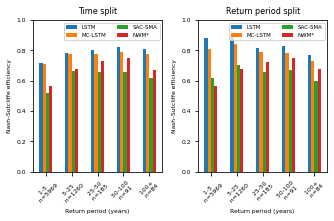

Abs. percent error of peak flow
                    LSTM   MC-LSTM   SAC-SMA      NWM*  count
1-5 \n n=5969   0.248522  0.248325  0.270660  0.311719   6175
5-25 \n n=1260  0.265932  0.285807  0.386195  0.336493   1309
25-50 \n n=185  0.312416  0.363309  0.488471  0.350870    191
50-100 \n n=91  0.284652  0.340177  0.519356  0.381218     97
100+ \n n=84    0.303466  0.355132  0.539820  0.498710     87
                    LSTM   MC-LSTM   SAC-SMA      NWM*  count
1-5 \n n=5969   0.124682  0.195283  0.270699  0.309130   5969
5-25 \n n=1260  0.129390  0.247666  0.417359  0.334243   1260
25-50 \n n=185  0.374311  0.392283  0.548077  0.355508    185
50-100 \n n=91  0.372538  0.413404  0.545642  0.381218     91
100+ \n n=84    0.401593  0.468788  0.583583  0.507474     84


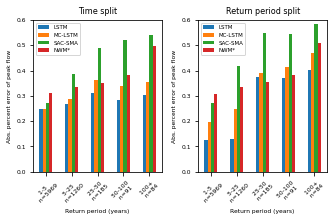

In [20]:
model_label_list = ['LSTM', 'MC-LSTM', 'SAC-SMA', 'NWM*']
model_name_list = ['lstm', 'mc', 'sac', 'nwm']
model_name_label_dict = {model_name:model_label for model_name, model_label in \
                         zip(model_name_list,model_label_list)}
model_ri_list = ['ri', 'lstm', 'mc', 'sac', 'nwm']
train_types = ['time_split','return_period_split']
ri_list = {}
ri_bins = {}
count_missing = {train_type:{} for train_type in train_types}
#for metric in all_metrics:
for metric in  ['NSE', 'peakQ-perc']:
    print(namz[metric])
    bin_max=[5, 25,50,100,1000000000]
    bin_names=['1-5 \n n=5969', '5-25 \n n=1260','25-50 \n n=185','50-100 \n n=91','100+ \n n=84']
    ri_list[metric] = {train_type:{model_label:{bin_name:[] for bin_name in bin_names} for \
                           model_label in model_label_list} for train_type in train_types}
    ri_bins[metric] = {train_type:{model_label:{bin_name:0 for bin_name in bin_names} for \
                           model_label in model_label_list} for train_type in train_types}
    for train_type in train_types:
        ri_bins[metric][train_type]['count'] = {bin_name:0 for bin_name in bin_names}
    
    count_missing['time_split'][metric] = {model_ri:0 for model_ri in model_ri_list}
    for i, ri in enumerate(analysis_dict['time_split'][metric]['ri']):
        if analysis_dict['time_split'][metric]['ri'][i] is None:
            continue
        
        skip_this=False
        for icheck in model_ri_list:
            if analysis_dict['time_split'][metric][icheck][i] is None:
                skip_this=True
                count_missing['time_split'][metric][icheck]+=1
            if np.isinf(analysis_dict['time_split'][metric][icheck][i]):
                skip_this=True
                count_missing['time_split'][metric][icheck]+=1
            if isinstance(analysis_dict['time_split'][metric][icheck][i], str):
                skip_this=True
                count_missing['time_split'][metric][icheck]+=1
            if analysis_dict['time_split'][metric][icheck][i] != analysis_dict['time_split'][metric][icheck][i]:
                skip_this=True
                count_missing['time_split'][metric][icheck]+=1

        if skip_this:
            continue
            skip_this=False

        for maxv,bin_name in zip(bin_max, bin_names):
            if ri<maxv:
                ri_bins[metric]['time_split']['count'][bin_name]+=1
                for model_name, model_label in zip(model_name_list, model_label_list):
                    ri_list[metric]['time_split'][model_label][bin_name].append( \
                                                    analysis_dict['time_split'][metric][model_name][i])
                break
                
    count_missing['return_period_split'][metric] = {model_ri:0 for model_ri in model_ri_list}
    for i, ri in enumerate(analysis_dict['return_period_split'][metric]['ri']):
        if analysis_dict['return_period_split'][metric]['ri'][i] is None:
            continue
        
        skip_this=False
        for icheck in model_ri_list:
            if analysis_dict['return_period_split'][metric][icheck][i] is None:
                skip_this=True
                count_missing['return_period_split'][metric][icheck]+=1
            if np.isinf(analysis_dict['return_period_split'][metric][icheck][i]):
                skip_this=True
                count_missing['return_period_split'][metric][icheck]+=1
            if isinstance(analysis_dict['return_period_split'][metric][icheck][i], str):
                skip_this=True
                count_missing['return_period_split'][metric][icheck]+=1
            if analysis_dict['return_period_split'][metric][icheck][i] != analysis_dict['return_period_split'][metric][icheck][i]:
                skip_this=True
                count_missing['return_period_split'][metric][icheck]+=1

        if skip_this:
            continue
            skip_this=False

        for maxv,bin_name in zip(bin_max, bin_names):
            if ri<maxv:
                ri_bins[metric]['return_period_split']['count'][bin_name]+=1
                for model_name, model_label in zip(model_name_list, model_label_list):
                    ri_list[metric]['return_period_split'][model_label][bin_name].append( \
                                                        analysis_dict['return_period_split'][metric][model_name][i])
                break
                                
                
    for maxv,bin_name in zip(bin_max, bin_names):
        if ri_bins[metric]['time_split']['count'][bin_name] < 1:
            continue
        for model_label in model_label_list:
            if metric == 'peakT-abs':
                ri_bins[metric]['time_split'][model_label][bin_name] = np.nanmean( \
                                                            ri_list[metric]['time_split'][model_label][bin_name])            
            else:
                ri_bins[metric]['nwm'][model_label][bin_name] = np.nanmedian( \
                                                            ri_list[metric]['time_split'][model_label][bin_name])
        if ri_bins[metric]['return_period_split']['count'][bin_name] < 1:
            continue
        for model_label in model_label_list:
            if metric == 'Peak-Timing':
                ri_bins[metric]['return_period_split'][model_label][bin_name] = np.nanmean( \
                                                            ri_list[metric]['return_period_split'][model_label][bin_name])            
            else:
                ri_bins[metric]['return_period_split'][model_label][bin_name] = np.nanmedian( \
                                                            ri_list[metric]['return_period_split'][model_label][bin_name])

    fig = plt.figure(figsize=cm2inch(12,8))
#    plt.suptitle(metric)
    print(pd.DataFrame(ri_bins[metric]['time_split']))
    ax = fig.add_subplot(1, 2, 1)    
    pd.DataFrame(ri_bins[metric]['time_split'])[model_label_list].plot.bar(ax=ax)
    ax.set_ylabel(namz[metric])
    ax.set_xlabel('Return period (years)')
    ax.set_xticklabels(bin_names, rotation = 45)
    ax.set_ylim(ylimz_bar[metric])
    ax.legend(loc=legend_locz[metric], ncol=colz[metric], fontsize=5.5)
    ax.set_title('Time split')
    
    print(pd.DataFrame(ri_bins[metric]['return_period_split']))
    ax = fig.add_subplot(1, 2, 2)
    pd.DataFrame(ri_bins[metric]['return_period_split'])[model_label_list].plot.bar(ax=ax)
    ax.set_ylabel(namz[metric])
    ax.set_xlabel('Return period (years)')
    ax.set_xticklabels(bin_names, rotation = 45)
    ax.set_ylim(ylimz_bar[metric])
#    ax.get_legend().remove()
    ax.legend(loc=legend_locz[metric], ncol=colz[metric], fontsize=5.5)
    ax.set_title('Return period split')
        
    fig.tight_layout(pad=1.0)
#     fig.savefig('figs/paper-mc-lstm-4june2021/bars_{}.pdf'.format(metric), dpi=600)
#     fig.savefig('figs/paper-mc-lstm-4june2021/bars_{}.png'.format(metric), dpi=600)
    plt.show()
    plt.close()

In [ ]:
with open('./model_output_for_analysis/nwm_chrt_v2_1d_local.p', 'rb') as fb:
    nwm_results = pkl.load(fb)
    
with open('./model_output_for_analysis/lstm_time_split.p', 'rb') as fb:
    lstm_results_time_split = pkl.load(fb)
with open('./model_output_for_analysis/mclstm_time_split.p', 'rb') as fb:
    mclstm_results_time_split = pkl.load(fb)
with open('./model_output_for_analysis/sacsma_time_split.p', 'rb') as fb:
    sacsma_results_time_split = pkl.load(fb)

In [27]:
total_mass_error = {'absolute':{flow:[] for flow in flows}, 
              'positive':{flow:[] for flow in flows}, 
              'negative':{flow:[] for flow in flows}}
total_mass = {}
labelz={'nwm':'NWM*', 'lstm':'LSTM', 'mc':'MC-LSTM','sac':'SAC-SMA', 'obs':'Observed'}

start_date = pd.Timestamp('1996-10-01')
end_date = pd.Timestamp('2014-01-01')

plot_cum_mass = False

read_values = False
if read_values:
    with open('total_mass_error_NWM.pkl', 'rb') as fb:
        total_mass_error = pkl.load(fb)
    with open('total_mass_NWM.pkl', 'rb') as fb:
        total_mass = pkl.load(fb)
else:
    for basin_0str in basin_list:
        basin_int = int(basin_0str)
        print(basin_0str)

        #-------------------------------------------------------------------------------------------------
        # Reset the total mass to zero for this basin    
        cumulative_mass = {flow:[0] for flow in flows}
        cumulative_mass['precip'] = [0]
        total_mass[basin_0str] = {flow:0 for flow in flows}
        imass=1
        #-------------------------------------------------------------------------------------------------


        #-------------------------------------------------------------------------------------------------
        # We need the basin area to convert to CFS, to interpolate the RI from LPIII
        basin_area = pd_attributes.loc[basin_int, 'area_geospa_fabric']
        basin_str = tools.gauge_id_str(basin_int)
        #-------------------------------------------------------------------------------------------------

        #-------------------------------------------------------------------------------------------------
        # Make dictionary with all the flows
        flow_mm = {}    
        #-------------------------------------------------------------------------------------------------
        # Get the NWM data for this basin in an xarray dataset.
        xr_nwm = xr.DataArray(nwm_results[basin_0str]['streamflow'].values, 
                 coords=[nwm_results[basin_0str]['streamflow'].index], 
                 dims=['datetime'])
        # convert from CFS to mm/day
        # fm3/s * 3600 sec/hour * 24 hour/day / (m2 * mm/m)
        flow_mm['nwm'] = xr_nwm*3600*24/(basin_area*1000)
        #-------------------------------------------------------------------------------------------------
        # Standard LSTM 
        xrr = lstm_results_time_split[basin_0str]['1D']['xr']['QObs(mm/d)_sim']
        flow_mm['lstm'] = pd.DataFrame(data=xrr.values,index=xrr.date.values)
        #-------------------------------------------------------------------------------------------------
        # Mass-conserving LSTM data trained on all years
        xrr = lstm_results_time_split[basin_0str]['1D']['xr']['QObs(mm/d)_sim']
        flow_mm['mc'] = pd.DataFrame(data=xrr.values,index=xrr.date.values)
        #-------------------------------------------------------------------------------------------------
        # SACSMA Ensemble Mean
        df = sacsma_results_time_split[basin_0str]
        flow_mm['sac'] = df
        #-------------------------------------------------------------------------------------------------
        # OBSERVATIONS
        xrr = mclstm_results_time_split[basin_0str]['1D']['xr']['QObs(mm/d)_obs']
        flow_mm['obs'] = pd.DataFrame(data=xrr.values,index=xrr.date.values)
        #-------------------------------------------------------------------------------------------------
        # FORCING
        forcing = pd.read_csv(data_dir+basin_0str+'_lump_cida_forcing_leap.txt', delim_whitespace=True, header=3)
        forcing.index=pd.to_datetime((forcing.Year*10000+forcing.Mnth*100+forcing.Day).apply(str),format='%Y%m%d')
        #-------------------------------------------------------------------------------------------------


        #-------------------------------------------------------------------------------------------------
        # Make sure we are in a time period that all the flow members have values
        for d in mclstm_results_0_nwm_train[basin_0str]['1D']['xr']['QObs(mm/d)_obs'].date:
            if d.values < start_date:
                continue
            if d.values > end_date:
                break
            if np.isnan(flow_mm['obs'].loc[d.values].values[0]):
                continue

        #-------------------------------------------------------------------------------------------------


            #-------------------------------------------------------------------------------------------------
            # Keep track of the cumulative mass and add it to the list
            cumulative_mass['precip'].append(forcing['prcp(mm/day)'].loc[d.values] + \
                                             cumulative_mass['precip'][imass-1])
            cumulative_mass['obs'].append(flow_mm['obs'].loc[d.values].values[0] + \
                                          cumulative_mass['obs'][imass-1])
            cumulative_mass['nwm'].append(flow_mm['nwm'].loc[d.values].values + \
                                          cumulative_mass['nwm'][imass-1])
            cumulative_mass['lstm'].append(flow_mm['lstm'].loc[d.values].values[0] + \
                                           cumulative_mass['lstm'][imass-1])
            cumulative_mass['mc'].append(flow_mm['mc'].loc[d.values].values[0] + \
                                         cumulative_mass['mc'][imass-1])
            cumulative_mass['sac'].append(flow_mm['sac'].loc[d.values] + \
                                          cumulative_mass['sac'][imass-1])
            imass+=1
            #-------------------------------------------------------------------------------------------------

        for flow in flows:
            total_mass[basin_0str][flow] = np.nansum(flow_mm[flow].loc[start_date:end_date])

        for flow in flows:
            total_mass_error['absolute'][flow].append(np.abs(total_mass[basin_0str][flow] - \
                                                             total_mass[basin_0str]['obs'])/ \
                                                             total_mass[basin_0str]['obs'])
            if (total_mass[basin_0str][flow] - total_mass[basin_0str]['obs']) > 0:
                total_mass_error['positive'][flow].append((total_mass[basin_0str][flow] - \
                                                           total_mass[basin_0str]['obs'])/ \
                                                           total_mass[basin_0str]['obs'])
                total_mass_error['negative'][flow].append(0)
            else:
                total_mass_error['negative'][flow].append((total_mass[basin_0str][flow] - \
                                                           total_mass[basin_0str]['obs']) / \
                                                           total_mass[basin_0str]['obs'])
                total_mass_error['positive'][flow].append(0)
                    
        if plot_cum_mass:
            fig = plt.figure(figsize=cm2inch(8.3,8))
            for flow in flows:
                plt.plot(cumulative_mass[flow], label=labelz[flow])
            plt.plot(cumulative_mass['precip'], label='Precipitation')
            plt.legend()
            plt.title(basin_0str)
            plt.ylabel('total water [mm]')
            plt.xlabel('simulation time (days)')
            fig.tight_layout()
            plt.show()
            plt.close()

dump_values = True
if dump_values:
    with open('total_mass_error_NWM.pkl', 'wb') as fb:
        pkl.dump(total_mass_error, fb)
    with open('total_mass_NWM.pkl', 'wb') as fb:
        pkl.dump(total_mass, fb)
        
with open('total_mass_error_NWM.pkl', 'rb') as fb:
    total_mass_error = pkl.load(fb)

01434025
01047000
01170100
01365000
01139000
01350140
01195100
01137500
01484100
01423000
01350000
01162500
01187300
01031500
01054200
01435000
01439500
01139800
01415000
01466500
01123000
01414500
01134500
01073000
01451800
01440400
01078000
01181000
01055000
01440000
01169000
01413500
01052500
01057000
01022500
01350080
01144000
01411300
01491000
01510000
01516500
01532000
01550000
01552000
01539000
01567500
01542810
01568000
01543500
01547700
01543000
01549500
01545600
01548500
01606500
01605500
01596500
01544500
01583500
01586610
01580000
01591400
01644000
01634500
01638480
01639500
01667500
01666500
01669000
01669520
02011400
02015700
02016000
02028500
02027000
02017500
02018000
02038850
02046000
02064000
02051500
02053200
02059500
02065500
02056900
02074500
02070000
02069700
02081500
02082950
02096846
02111180
02092500
02112120
02111500
02102908
02118500
02125000
02112360
02137727
02140991
02143000
02152100
02177000
02193340
02215100
02196000
02198100
02178400
02216180
02212600
0

In [28]:
total_mass_error_dict = {}
for iplot, error_type in enumerate(['absolute', 'positive', 'negative']):
    print("error type: ", error_type)
    error_means = {}
    for tme_key in ['lstm', 'mc', 'sac', 'nwm']:
        print(tme_key, np.round(np.mean(total_mass_error[error_type][tme_key]),4))
        error_means[tme_key] = np.round(np.mean(total_mass_error[error_type][tme_key]),4)
    total_mass_error_dict[error_type] = error_means

error type:  absolute
lstm 0.1348
mc 0.1416
sac 0.3538
nwm 0.1781
error type:  positive
lstm 0.1091
mc 0.1073
sac 0.3191
nwm 0.0833
error type:  negative
lstm -0.0257
mc -0.0343
sac -0.0347
nwm -0.0948


<AxesSubplot:>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


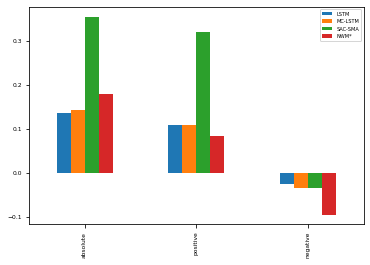

In [29]:
error_plot_df = pd.DataFrame(total_mass_error_dict).transpose()
error_plot_df = error_plot_df.rename(columns={'lstm':'LSTM', 'mc':'MC-LSTM', 'sac':'SAC-SMA', 'nwm':'NWM*'})
error_plot_df.plot.bar()


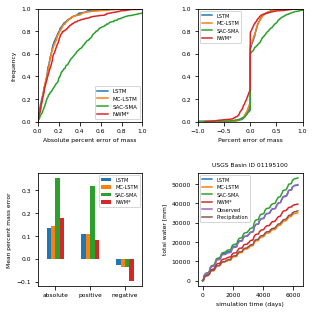

In [30]:
fig = plt.figure(figsize=cm2inch(12,12))
limz = {'absolute':([0,1],[0,1]), 'positive':([0,1],[0,1]), 
        'negative':([0,-1],[0,0.6]), 'neg-pos':([-1,1],[0,1])}
xlabz = {'absolute':'Absolute percent error of mass', 
         'positive':'Positive error of mass (percent)', 
         'negative':'Negative error of mass (percent)',
         'neg-pos':'Percent error of mass'}
yvalues={}
plotdata={}
for iplot, error_type in enumerate(['absolute', 'positive', 'negative']):

    plot_df = pd.DataFrame({model_label:total_mass_error[error_type][model_label] for model_label in models})    
    plotdata[error_type] = np.sort(plot_df[~pd.isnull(plot_df)], axis=0)
    
    if error_type == 'absolute':
        
        for model in models:
            yvalues[model] = list(range(len(total_mass_error[error_type][model])))
            for i, _ in enumerate(yvalues[model]):
                yvalues[model][i] = yvalues[model][i]/len(yvalues[model])        
        
        ax = fig.add_subplot(2, 2, 1)
        ax.plot(pd.DataFrame(data=plotdata[error_type], columns=model_label_list), 
                             yvalues[model][:len(plotdata[error_type])])
        ax.set_xlim(limz[error_type][0])
        ax.set_ylim(limz[error_type][1])
        ax.set_xlabel(xlabz[error_type])
        ax.set_ylabel("frequency")
        #plt.title("Abs. Percent Mass Error")
        plt.legend(model_label_list, fontsize=5.5)

    
combined_pos_neg_error = {}
for i, model in enumerate(models):
    combined_pos_neg_error[model] = list(np.append(plotdata['negative'][:,i], plotdata['positive'][:,i]))
plotdata2 = pd.DataFrame(combined_pos_neg_error)
    
ax = fig.add_subplot(2, 2, 2)
for model in models:
    yvalues[model] = list(range(plotdata2[model].shape[0]))
    for i, _ in enumerate(yvalues[model]):
        yvalues[model][i] = yvalues[model][i]/len(yvalues[model])
# plot_df = pd.DataFrame({model_label:combined_pos_neg_error[model] for model in models})    
plotdata['neg-pos'] = np.sort(plotdata2[~pd.isnull(plotdata2)], axis=0)
ax.plot(pd.DataFrame(data=plotdata['neg-pos'], columns=model_label_list), 
        yvalues[model][:len(plotdata['neg-pos'])])
ax.set_xlim(limz['neg-pos'][0])
ax.set_ylim(limz['neg-pos'][1])
ax.set_xlabel(xlabz['neg-pos'])
plt.legend(model_label_list)

ax = fig.add_subplot(2, 2, 4)
for flow in flows:
    ax.plot(cumulative_mass[flow], label=labelz[flow])
ax.plot(cumulative_mass['precip'], label='Precipitation')
plt.legend()
ax.set_title("USGS Basin ID 01195100", fontsize=6)
ax.set_ylabel('total water [mm]')
ax.set_xlabel('simulation time (days)')    

ax = fig.add_subplot(2, 2, 3)
error_plot_df.plot.bar(ax=ax)
ax.set_xticklabels(['absolute', 'positive', 'negative'], rotation = 0)
ax.set_ylabel("Mean percent mass error")

fig.tight_layout(pad=2.0)
fig.savefig('figs/paper-mc-lstm-4june2021/mass_error_frequency.pdf', dpi=600)
fig.savefig('figs/paper-mc-lstm-4june2021/mass_error_frequency.png', dpi=600)
plt.show()
plt.close()